In [1]:
!pip3 install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


## Mean Shift Clustering Algorithm Implementation

In [15]:
# Add Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift as SklearnMeanShift
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score, calinski_harabasz_score, adjusted_mutual_info_score, mutual_info_score
from collections import deque
import importlib
import common.functions
importlib.reload(common.functions)

from common.functions import compute_gower_distance, visualize_clusters, compute_gower_distance_matrix

### Load datasets

In [2]:
dataset_path = "./../datasets"

iris_dataset_path = dataset_path + "/iris.csv"                                         
ai_global_index_path = dataset_path + "/AI_index_db.csv"
global_earthquake_data_path = dataset_path + "/earthquakes.csv"

In [3]:
iris_df = pd.read_csv(iris_dataset_path)
ai_global_index_df = pd.read_csv(ai_global_index_path)
global_earthquake_data_df = pd.read_csv(global_earthquake_data_path)

iris_df = iris_df.drop(columns=['species'])


ai_global_index_df = ai_global_index_df.drop(columns=['Country', 'Cluster'])

ai_global_index_categorical_cols = ['Income group', 'Political regime', 'Region']
ai_global_index_numerical_cols = [
    "Talent", 
    "Infrastructure", 
    "Operating Environment", 
    "Research", 
    "Development", 
    "Government Strategy", 
    "Commercial", 
    "Total score"
]

income_order = {'Lower middle': 0, 'Upper middle': 1, 'High': 2}
ai_global_index_df['Income group'] = ai_global_index_df['Income group'].map(income_order)
# ai_global_index_df = pd.get_dummies(ai_global_index_df, columns=ai_global_index_categorical_cols)

earthquake_drop_cols = [
    'id', 'title', 'date', 'time', 'updated', 'url', 'detailUrl', 
    'ids', 'sources', 'types', 'place', 'placeOnly', 'location', 
    'what3words', 'locationDetails'
]
global_earthquake_data_df = global_earthquake_data_df.drop(columns=earthquake_drop_cols)


earthquake_categorical_cols = [
    'type', 'alert', 'status', 'net', 'magType', 'geometryType',
    'continent', 'country', 'subnational', 'city', 'locality', 'postcode', 'timezone'
]
earthquake_numerical_cols = [
    "magnitude", "felt", "cdi", "mmi", "tsunami", "sig",
    "nst", "dmin", "rms", "gap", "depth", "latitude",
    "longitude", "distanceKM"
]
global_earthquake_data_df[earthquake_categorical_cols] = global_earthquake_data_df[earthquake_categorical_cols]
# global_earthquake_data_df = pd.get_dummies(global_earthquake_data_df, columns=earthquake_categorical_cols)

datasets = {
    "iris": iris_df,
    "ai_global_index": ai_global_index_df,
    "global_earthquake": global_earthquake_data_df
}

### Mean Shift Clustering Algorithm stated in report (see report/Part-I.pdf)

In [5]:
class CustomMeanShift:
    """
    A custom Mean Shift clustering implementation, suitable for
    comparison with scikit-learn's MeanShift.

    Parameters
    ----------
    bandwidth : float, default=1.0
        The radius within which points are considered neighbors.

    max_iter : int, default=300
        The maximum number of iterations for shifting each point.

    epsilon : float, default=1e-3
        Convergence threshold. If the shift distance is smaller than epsilon,
        the iteration stops for that point.

    merge_tol : float, default=1e-1
        Threshold distance for merging cluster centers.
        If two modes are within merge_tol of each other, they are merged
        into a single cluster center.

    Attributes
    ----------
    cluster_centers_ : ndarray of shape (n_clusters, n_features)
        Coordinates of cluster centers (modes).

    labels_ : ndarray of shape (n_samples,)
        Labels of each point.
    """
    def __init__(self, bandwidth=1.0, max_iter=300, epsilon=1e-3, merge_tol=1e-1):
        self.bandwidth = bandwidth
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.merge_tol = merge_tol

        self.cluster_centers_ = None
        self.labels_ = None

    def _shift_point(self, X, start_idx):
        """
        Perform the mean shift procedure for a single point, returning
        the converged mode.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            The input data.

        start_idx : int
            Index of the point in X from which to start shifting.

        Returns
        -------
        mode : ndarray of shape (n_features,)
            The converged mode for the starting point.
        """
        y = X[start_idx].copy()
        for _ in range(self.max_iter):
            # Find neighbors within bandwidth
            diff = X - y
            dist_sq = np.sum(diff**2, axis=1)
            in_band = dist_sq < (self.bandwidth ** 2)

            # Compute the mean of neighbors
            neighbors = X[in_band]
            y_new = neighbors.mean(axis=0)

            # Check for convergence
            shift_dist = np.linalg.norm(y_new - y)
            y = y_new
            if shift_dist < self.epsilon:
                break

        return y

    def _merge_modes(self, modes):
        """
        Merge similar modes that are within merge_tol of each other.

        Parameters
        ----------
        modes : list of ndarray
            List of converged modes (one per sample).

        Returns
        -------
        merged_centers : list of ndarray
            Final cluster centers after merging.
        """
        merged_centers = []

        for mode in modes:
            found_similar = False
            for i, center in enumerate(merged_centers):
                if np.linalg.norm(mode - center) < self.merge_tol:
                    # Merge the mode with the existing center
                    merged_centers[i] = (center + mode) / 2.0
                    found_similar = True
                    break
            if not found_similar:
                merged_centers.append(mode)

        return merged_centers

    def fit(self, X):
        """
        Compute Mean Shift clustering.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            The input data.

        Returns
        -------
        self : object
            Fitted estimator.
        """
        n_samples, n_features = X.shape

        # Step 1: Shift each point to find its mode
        all_modes = []
        for i in range(n_samples):
            mode = self._shift_point(X, i)
            all_modes.append(mode)

        # Step 2: Merge modes that are close together
        merged_centers = self._merge_modes(all_modes)
        self.cluster_centers_ = np.array(merged_centers)

        # Step 3: Assign each sample to the nearest cluster center
        self.labels_ = np.zeros(n_samples, dtype=int)
        for i in range(n_samples):
            distances = np.linalg.norm(self.cluster_centers_ - X[i], axis=1)
            self.labels_[i] = np.argmin(distances)

        return self

    def predict(self, X):
        """
        Assign each point in X to the nearest cluster center found during fit.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            New data to predict.

        Returns
        -------
        labels : ndarray of shape (n_samples,)
            Index of the cluster each sample belongs to.
        """
        if self.cluster_centers_ is None:
            raise ValueError("Must call fit before predict.")

        labels = np.zeros(len(X), dtype=int)
        for i in range(len(X)):
            distances = np.linalg.norm(self.cluster_centers_ - X[i], axis=1)
            labels[i] = np.argmin(distances)
        return labels

    def fit_predict(self, X):
        """
        Compute cluster centers and predict cluster index for each sample.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            The input data.

        Returns
        -------
        labels : ndarray of shape (n_samples,)
            Index of the cluster each sample belongs to.
        """
        self.fit(X)
        return self.labels_


### Comparing our custom implementation with that of Sci-kit Learn's

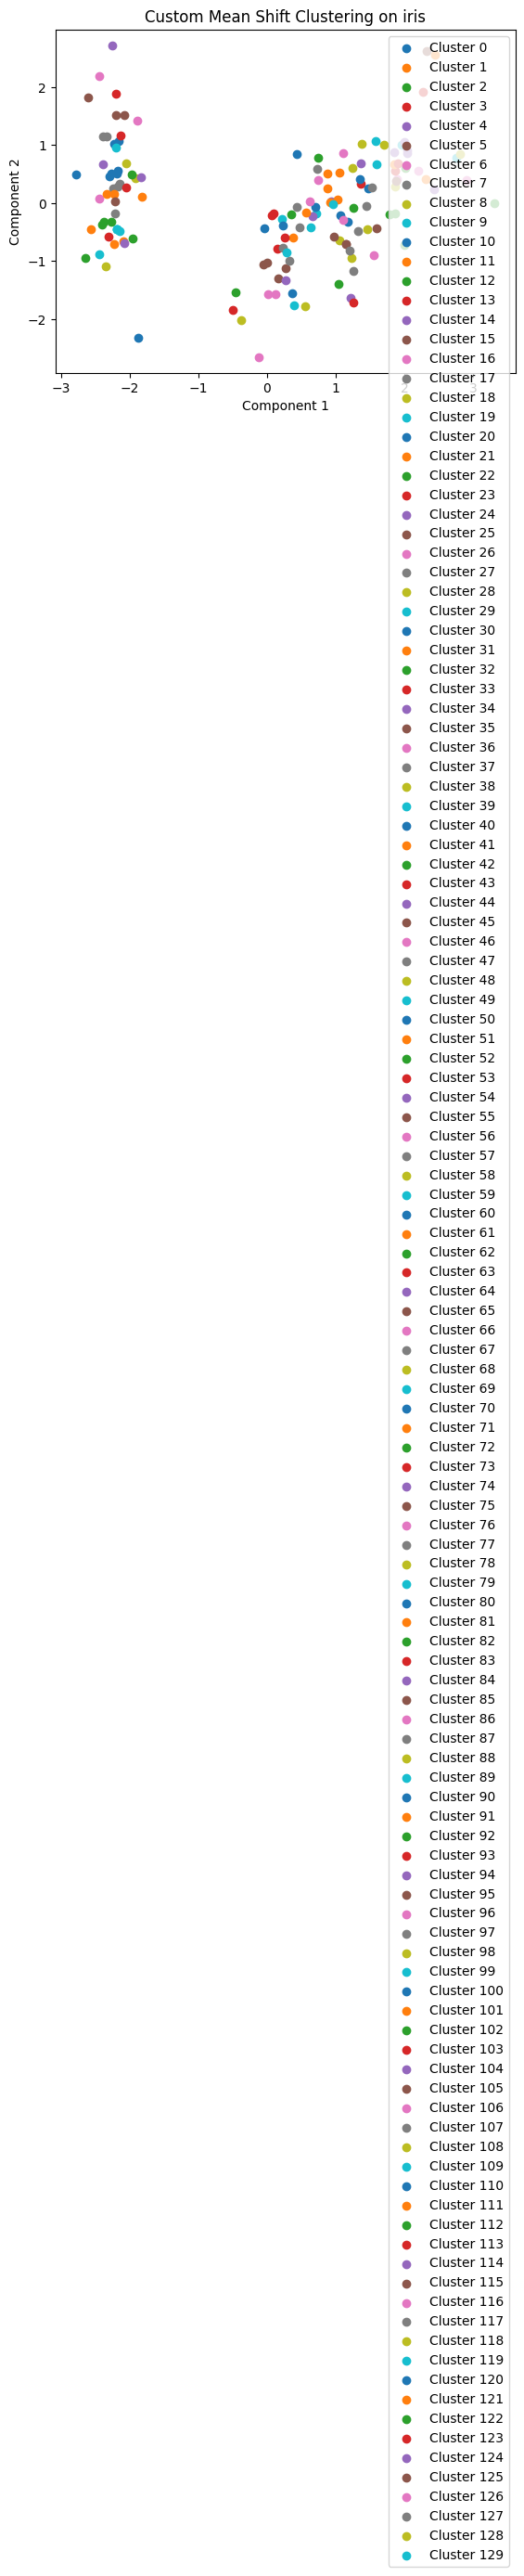

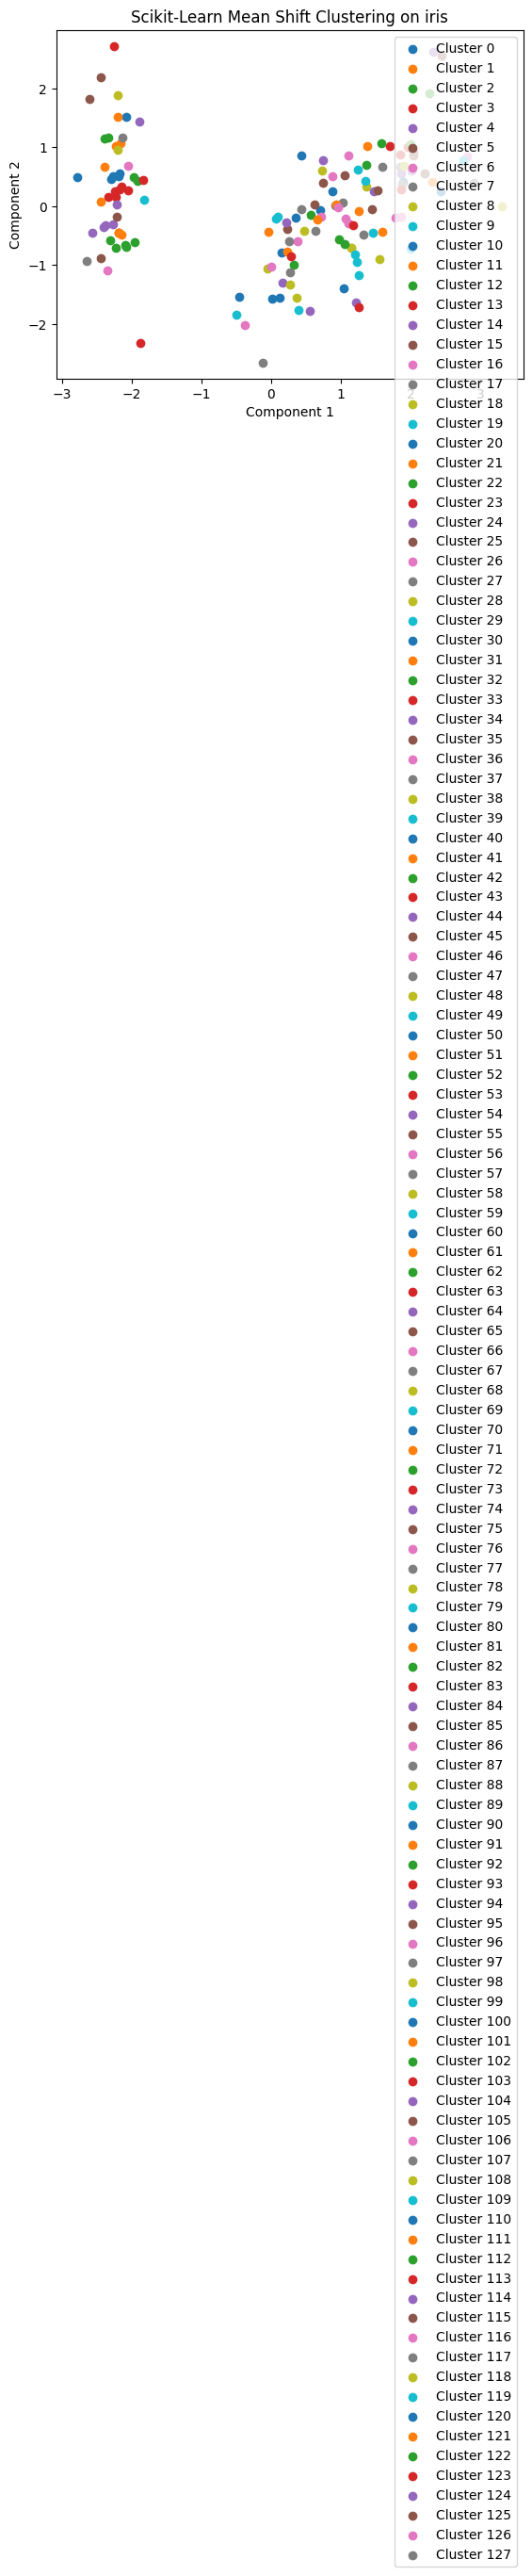

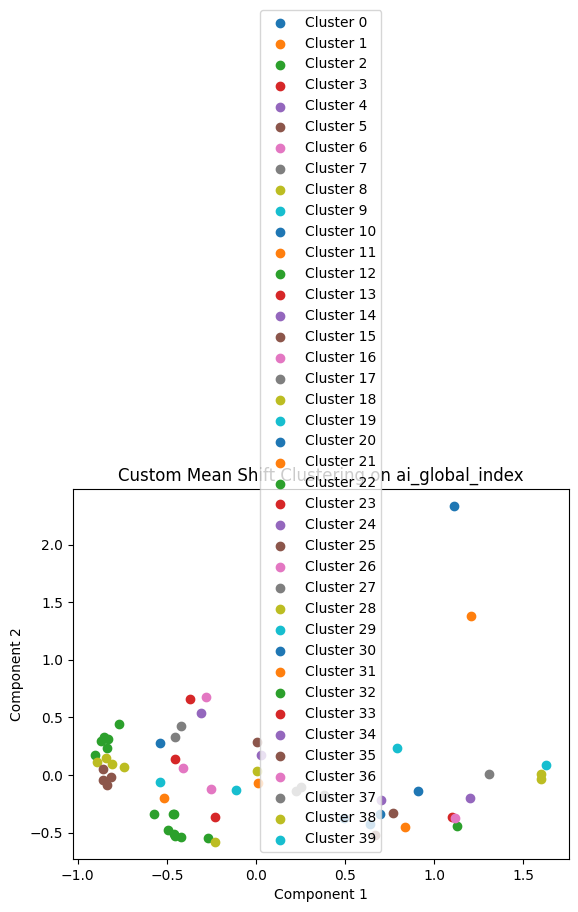

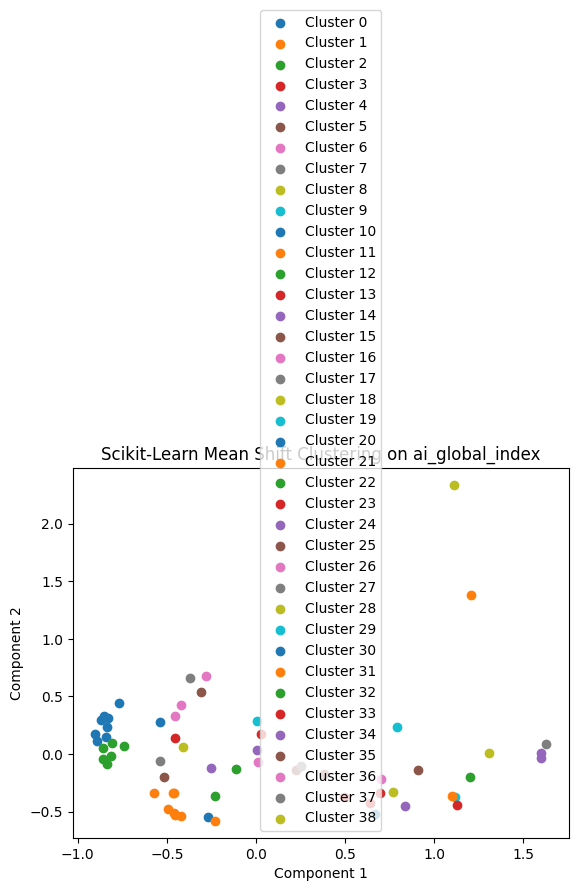

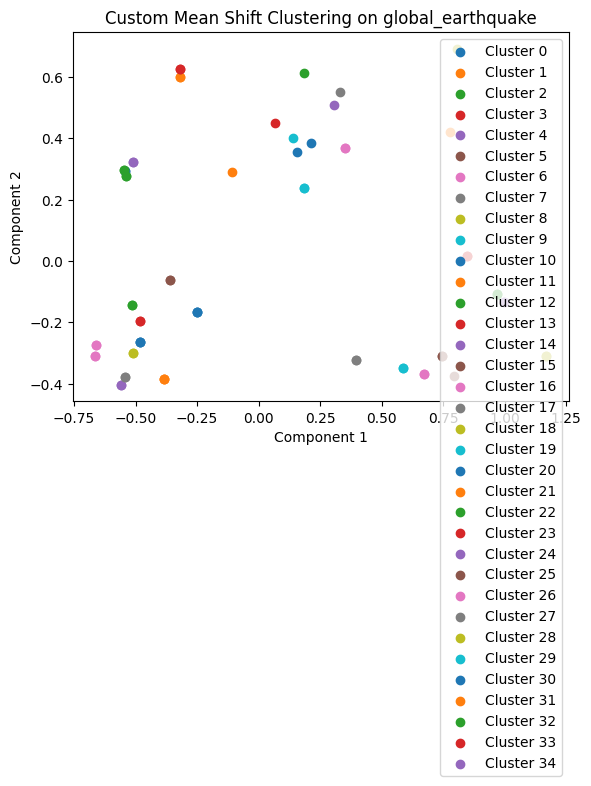

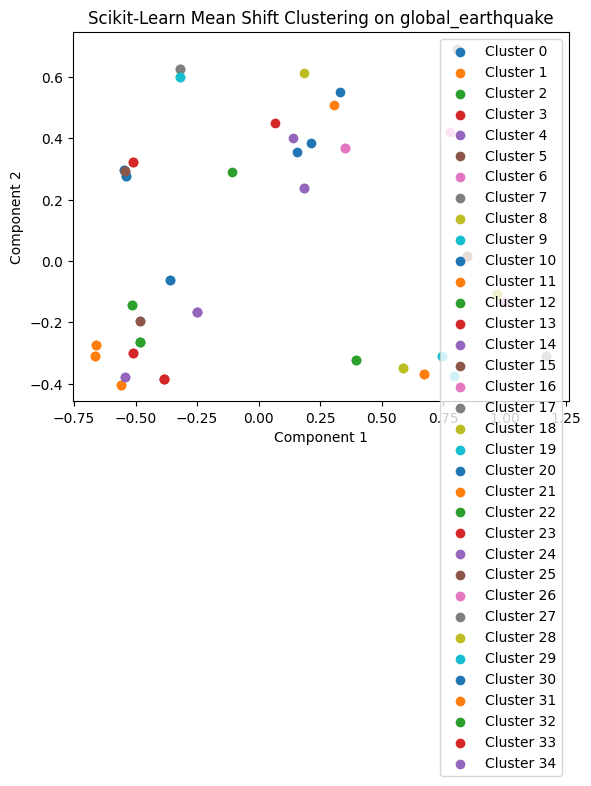

In [17]:
results = []

for name, df in datasets.items():
    metric = None
    # Preprocessing:
    # For the iris dataset, remove the species column (assumed to be the last column)
    if name == "iris":
        # Remove species label (assumed to be the last column), drop NaNs, and standardize.
        X = df.dropna().values
        X = StandardScaler().fit_transform(X)
        metric = 'euclidean'
    elif name == "ai_global_index":
        # For AI Global Index: use mixed data. Drop NaNs and compute Gower distance.
        df_clean = df.dropna()
        X = compute_gower_distance_matrix(df_clean, num_cols=ai_global_index_numerical_cols, cat_cols=ai_global_index_categorical_cols)
        metric = 'precomputed'
    elif name == "global_earthquake":
        # For Global Earthquake: use mixed data. Drop NaNs and compute Gower distance.
        df_clean = df.dropna()
        X = compute_gower_distance_matrix(df_clean, num_cols=earthquake_numerical_cols, cat_cols=earthquake_categorical_cols)
        metric = 'precomputed'
    else:
        # For Global Earthquake: select numeric columns, drop NaNs, and standardize.
        X = df.select_dtypes(include=[np.number]).dropna().values
        X = StandardScaler().fit_transform(X)
        metric = 'euclidean'


    # ---------------------------
    # Custom Mean Shift Implementation
    # ---------------------------
    custom_ms = CustomMeanShift(bandwidth=0.2, merge_tol=0.1)
    start_time = time.time()
    labels_custom = custom_ms.fit_predict(X)
    custom_runtime = time.time() - start_time
    if metric == 'precomputed':
        custom_silhouette = silhouette_score(X, labels_custom, metric='precomputed') if len(set(labels_custom)) > 1 else None
    else:
        custom_silhouette = silhouette_score(X, labels_custom) if len(set(labels_custom)) > 1 else None
    results.append({
        "dataset": name,
        "type": "custom",
        "metric": metric,
        "silhouette": custom_silhouette,
        "runtime": custom_runtime,
        "cluster_count": len(set(labels_custom)) - (1 if -1 in labels_custom else 0),
        "noise_count": list(labels_custom).count(-1),
        # "labels": labels_custom.tolist()
    })
    visualize_clusters(X=X, labels=labels_custom, title=f"Custom Mean Shift Clustering on {name}", saveAs=f"{name}_mean_shift_custom")

    # ---------------------------
    # Scikit-Learn Mean Shift Implementation
    # ---------------------------
    start_time = time.time()
    if metric == 'precomputed':
        sklearn_ms = SklearnMeanShift(bandwidth=0.2)
    else:
        sklearn_ms = SklearnMeanShift(bandwidth=0.2)
    labels_sklearn = sklearn_ms.fit_predict(X)
    sklearn_runtime = time.time() - start_time
    if metric == 'precomputed':
        sklearn_silhouette = silhouette_score(X, labels_sklearn, metric='precomputed') if len(set(labels_sklearn)) > 1 else None
    else:
        sklearn_silhouette = silhouette_score(X, labels_sklearn) if len(set(labels_sklearn)) > 1 else None
    results.append({
        "dataset": name,
        "type": "sklearn",
        "metric": metric,
        "silhouette": sklearn_silhouette,
        "runtime": sklearn_runtime,
        "cluster_count": len(set(labels_sklearn)) - (1 if -1 in labels_sklearn else 0),
        "noise_count": list(labels_sklearn).count(-1),
        # "labels": labels_sklearn.tolist()
    })
    visualize_clusters(X=X, labels=labels_sklearn, title=f"Scikit-Learn Mean Shift Clustering on {name}", saveAs=f"{name}_mean_shift_sklearn")


# results_df = pd.DataFrame(results)
# results_df.to_csv("mean_shift_results.csv", index=False)
